# KITTI 里程计序列 07 轨迹实验指南

在 KITTI odometry 中的 sequence 07 轨迹上做实验，尝试回答以下问题：

## 实验任务

### 1. 欧拉角计算与分析
- 从数据库中提供的 Tr 矩阵中计算出俯仰、滚动、偏航等三个欧拉角。
- （KITTI 数据库并未指定欧拉角的旋转顺序，你可以尝试采用不同的旋转次序，比较不同次序恢复出的角度是否一致？哪一个次序更为合理？）

### 2. 姿态表示方法比较
- 从 Tr 矩阵中计算出单位四元数，比较四元数和欧拉角表示方法。
- 欧拉角中著名的 Gimbal Lock 问题在该组数据中或是在一般的地面无人平台数据中是否会出现？
- 欧拉角表示方法对于地面无人平台来说是否就足够用？
- 四元数的优点究竟体现在哪些方面？

### 3. 点云地图构建
- 利用 Tr 矩阵将前 50 帧雷达数据拼接起来生成一个局部地图。
- （为了避免数据过大，可以对数据进行降采样）

## 注意事项
- 注意 pose 中的坐标系可能为相机坐标系（x 向右，y 向下，z 向前）
- 雷达数据则是在雷达系下（x 向前，y 向左，z 向上）
- calib.txt 中存储了相机和雷达的外参，其具体含义请参见 KITTI 官网提供的 devkit 中的说明

## 0. 方法定义

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

class KittiPoseHandler:
    def __init__(self, base_dir):
        """
        初始化处理类，加载外参和位姿数据
        :param base_dir: 数据集根目录 (例如 '../data/07/')
        """
        self.base_dir = base_dir
        self.calib_file = base_dir + 'calib.txt'
        self.pose_file = base_dir + 'poses/orig_poses.txt' # 根据你截图中的路径
        
        # 1. 加载标定矩阵 Tr (LiDAR -> Camera)
        self.Tr = self._load_calib()
        self.Tr_inv = np.linalg.inv(self.Tr) # 缓存逆矩阵 (Camera -> LiDAR)
        
        # 2. 加载原始相机位姿列表 (C0 -> Ct)
        self.raw_camera_poses = self._load_poses()
        
        print(f"初始化完成:")
        print(f"- 标定矩阵 Tr shape: {self.Tr.shape}")
        print(f"- 位姿总帧数: {len(self.raw_camera_poses)}")

    def _load_calib(self):
        """内部函数：读取 calib.txt 并构建 4x4 Tr 矩阵"""
        with open(self.calib_file, 'r') as f:
            for line in f:
                if line.startswith('Tr:'):
                    # 提取数值并转为 numpy 数组
                    data = np.fromstring(line.split(':', 1)[1], sep=' ')
                    # 重塑为 3x4
                    tr_3x4 = data.reshape(3, 4)
                    # 补全为 4x4 齐次矩阵
                    tr_4x4 = np.eye(4)
                    tr_4x4[:3, :] = tr_3x4
                    return tr_4x4
        raise ValueError("在 calib.txt 中未找到 'Tr:'")

    def _load_poses(self):
        """内部函数：读取 poses.txt 并转换为 4x4 矩阵列表"""
        poses_data = np.loadtxt(self.pose_file)
        pose_matrices = []
        for row in poses_data:
            # 将 12 个数重塑为 3x4，再补全为 4x4
            pose = np.eye(4)
            pose[:3, :] = row.reshape(3, 4)
            pose_matrices.append(pose)
        return pose_matrices

    def get_pose_in_world(self, frame_id, sensor_type='lidar'):
        """
        获取指定帧、指定传感器在世界坐标系(L0)下的位姿
        
        公式:
        W_P_Ct = Tr_inv * C0_P_Ct
        W_P_Lt = W_P_Ct * Tr
        
        :param frame_id: 帧号
        :param sensor_type: 'lidar' 或 'camera' (左目)
        :return: 4x4 齐次变换矩阵
        """
        if frame_id >= len(self.raw_camera_poses):
            raise IndexError("Frame ID out of range")
            
        # 1. 获取原始相机位姿 (C0 -> Ct)
        pose_c0_ct = self.raw_camera_poses[frame_id]
        
        # 2. 计算世界系下的相机位姿 (L0 -> Ct)
        # W_T_Ct = L0_T_C0 * C0_T_Ct = Tr_inv * C0_P_Ct
        pose_world_cam = self.Tr_inv @ pose_c0_ct
        
        if sensor_type == 'camera':
            return pose_world_cam
            
        elif sensor_type == 'lidar':
            # 3. 计算世界系下的雷达位姿 (L0 -> Lt)
            # W_T_Lt = W_T_Ct * Ct_T_Lt
            # 因为雷达相机相对静止，Ct_T_Lt = C0_T_L0 = Tr
            pose_world_lidar = pose_world_cam @ self.Tr
            return pose_world_lidar
        
        else:
            raise ValueError("sensor_type must be 'lidar' or 'camera'")

def get_rotation_matrix(axis, degrees):
    """ 生成基础旋转矩阵 """
    rad = np.radians(degrees)
    c, s = np.cos(rad), np.sin(rad)
    if axis == 'x':
        return np.array([[1, 0, 0], [0, c, -s], [0, s, c]])
    elif axis == 'y':
        return np.array([[c, 0, s], [0, 1, 0], [-s, 0, c]])
    elif axis == 'z':
        return np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])



base_dir = '../data/07/'
handler = KittiPoseHandler(base_dir)

初始化完成:
- 标定矩阵 Tr shape: (4, 4)
- 位姿总帧数: 1101


In [2]:
import matplotlib.pyplot as plt
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

def plot_trajectory(handler, sensor_type='lidar', dim='3d', title_suffix="", arrow_step=100):
    """
    绘制轨迹图，支持 2D 或 3D，并在起点、终点以及沿途使用箭头指示运动方向。
    返回 matplotlib 的 figure 对象。

    :param handler: KittiPoseHandler 实例
    :param sensor_type: 'lidar' 或 'camera'
    :param dim: '2d' 或 '3d' (默认 '3d')
    :param title_suffix: 标题后缀 (可选)
    :param arrow_step: 沿途每隔多少帧画一个箭头 (默认 100)
    :return: matplotlib.figure.Figure 对象
    """

    num_frames = len(handler.raw_camera_poses)
    traj_world = []

    for i in range(num_frames):
        pose = handler.get_pose_in_world(i, sensor_type)
        traj_world.append(pose[:3, 3])

    traj_world = np.array(traj_world)

    if len(traj_world) < 10:
        print("数据点太少，无法绘制轨迹方向")
        return None

    fig = plt.figure(figsize=(10, 8)) 

    # --- 1. 设置样式 ---
    if sensor_type == 'lidar':
        traj_color = 'blue'
        label = 'LiDAR'
        alpha = 0.6
    else:
        traj_color = 'red'
        label = 'Camera'
        alpha = 0.8

    # --- 2. 计算方向箭头数据 ---
    gap = 5
    # 起点
    start_pos = traj_world[0]
    start_vec = traj_world[gap] - start_pos
    start_dir = start_vec / np.linalg.norm(start_vec)
    
    # 终点
    end_pos = traj_world[-1]
    end_vec = end_pos - traj_world[-1 - gap]
    end_dir = end_vec / np.linalg.norm(end_vec)
    
    # 沿途箭头数据收集
    mid_arrows = [] # list of (pos, dir)
    # 从 gap 帧开始，到倒数第 gap 帧结束，步长为 arrow_step
    # 确保不覆盖起点和终点
    for i in range(arrow_step, num_frames - gap, arrow_step):
        curr_pos = traj_world[i]
        # 使用前后帧计算切线方向
        vec = traj_world[i + gap] - traj_world[i]
        norm = np.linalg.norm(vec)
        if norm > 0.1: # 只有位移足够大才画箭头
            direction = vec / norm
            mid_arrows.append((curr_pos, direction))

        
    span = np.ptp(traj_world, axis=0).max()
    arrow_length = span * 0.10 

    # ==========================================
    # 3D 绘图逻辑
    # ==========================================
    if dim == '3d':
        ax = fig.add_subplot(111, projection='3d')
        
        # 绘制主轨迹
        ax.plot(traj_world[:, 0], traj_world[:, 1], traj_world[:, 2], 
                label=f'{label} Path', color=traj_color, linewidth=1, alpha=alpha)
        
        # 绘制起点终点箭头
        ax.quiver(start_pos[0], start_pos[1], start_pos[2], 
                  start_dir[0], start_dir[1], start_dir[2], 
                  length=arrow_length, color='green', linewidth=2.5, label='Start', arrow_length_ratio=0.3)
        ax.scatter(start_pos[0], start_pos[1], start_pos[2], c='green', s=50)

        ax.quiver(end_pos[0], end_pos[1], end_pos[2], 
                  end_dir[0], end_dir[1], end_dir[2], 
                  length=arrow_length, color='red', linewidth=2.5, label='End', arrow_length_ratio=0.3)
        ax.scatter(end_pos[0], end_pos[1], end_pos[2], c='red', s=50, marker='x')
        
        # 绘制沿途黄色箭头
        for pos, direction in mid_arrows:
            ax.quiver(pos[0], pos[1], pos[2], 
                      direction[0], direction[1], direction[2], 
                      length=arrow_length * 0.8, color='gold', linewidth=1.5, arrow_length_ratio=0.3) # 黄色箭头稍微短一点细一点

        ax.set_zlabel("Z (m)")
        
        # 强制等比例 (3D)
        x_limits = ax.get_xlim3d(); y_limits = ax.get_ylim3d(); z_limits = ax.get_zlim3d()
        ranges = [np.ptp(l) for l in [x_limits, y_limits, z_limits]]
        plot_radius = 0.5 * max(ranges)
        mid_x, mid_y, mid_z = np.mean(x_limits), np.mean(y_limits), np.mean(z_limits)
        ax.set_xlim3d([mid_x - plot_radius, mid_x + plot_radius])
        ax.set_ylim3d([mid_y - plot_radius, mid_y + plot_radius])
        ax.set_zlim3d([mid_z - plot_radius, mid_z + plot_radius])

    # ==========================================
    # 2D 绘图逻辑 (X-Y 平面俯视图)
    # ==========================================
    elif dim == '2d':
        ax = fig.add_subplot(111)
        
        # 绘制主轨迹 (只取 x, y)
        ax.plot(traj_world[:, 0], traj_world[:, 1], 
                label=f'{label} Path', color=traj_color, linewidth=1, alpha=alpha)
        
        # 计算 2D arrow scale
        arrow_scale = 1.0 / arrow_length

        # 绘制起点终点箭头
        ax.quiver(start_pos[0], start_pos[1], start_dir[0], start_dir[1], 
                  color='green', scale=arrow_scale, scale_units='xy', angles='xy', 
                  width=0.01, label='Start')
        ax.scatter(start_pos[0], start_pos[1], c='green', s=50, zorder=5)

        ax.quiver(end_pos[0], end_pos[1], end_dir[0], end_dir[1], 
                  color='red', scale=arrow_scale, scale_units='xy', angles='xy', 
                  width=0.01, label='End')
        ax.scatter(end_pos[0], end_pos[1], c='red', s=50, marker='x', zorder=5)

        # 绘制沿途黄色箭头
        for pos, direction in mid_arrows:
            ax.quiver(pos[0], pos[1], direction[0], direction[1], 
                      color='gold', scale=arrow_scale, scale_units='xy', angles='xy', 
                      width=0.01, headwidth=3) # 黄色箭头

        ax.grid(True, linestyle='--', alpha=0.5)
        ax.set_aspect('equal', 'box') 

    else:
        raise ValueError("dim must be '2d' or '3d'")

    # --- 公共设置 ---
    ax.set_title(f"{dim.upper()} Trajectory: {label} {title_suffix}")
    ax.set_xlabel("X (m)")
    ax.set_ylabel("Y (m)")
    # 只添加一次 Mid Direction 图例标签，避免重复
    if mid_arrows:
         # 创建一个空的 proxy artist 用于图例
         import matplotlib.lines as mlines
         mid_arrow_legend = mlines.Line2D([], [], color='gold', marker='>', linestyle='None',
                                  markersize=10, label='Mid Direction')
         handles, labels = ax.get_legend_handles_labels()
         handles.append(mid_arrow_legend)
         ax.legend(handles=handles)
    else:
        ax.legend()

    plt.tight_layout()
    
    plt.show()

# --- 使用示例 ---
# fig3d = plot_trajectory(handler, sensor_type='lidar', dim='3d', arrow_step=200)
# plt.show()

# fig2d = plot_trajectory(handler, sensor_type='lidar', dim='2d', arrow_step=150)
# plt.show()

## Q1 

### 不同次序下的欧拉角解算可视化

使用handler.get_pose_in_world(i, 'lidar')获取第i帧的雷达位姿在世界系下的位姿，然后使用不同顺序求解欧拉角。这里的世界系被定义为t=0时刻的雷达系。

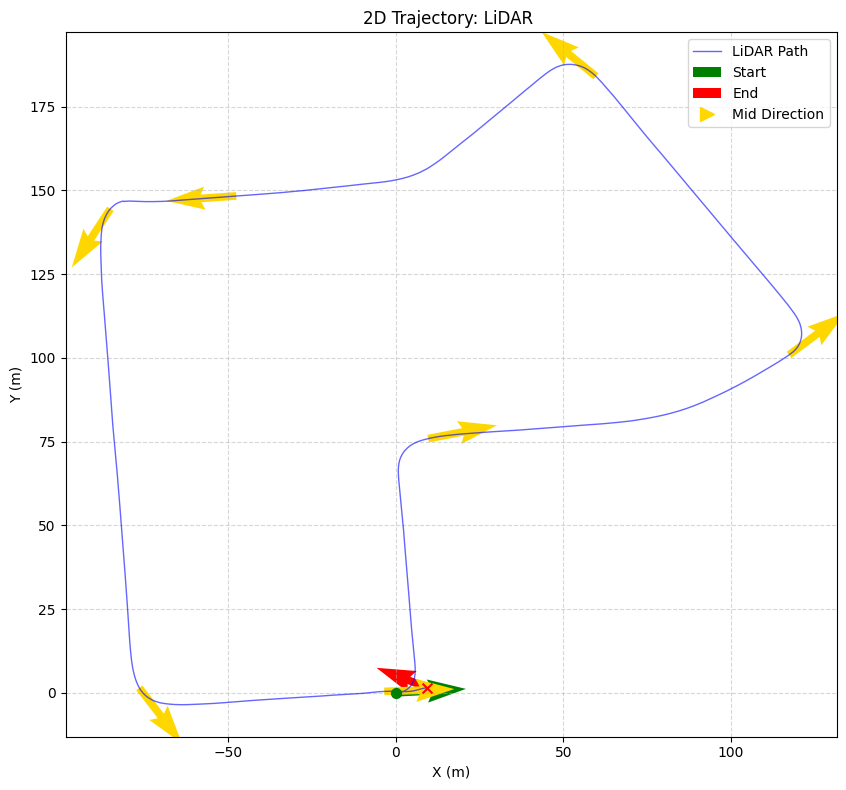

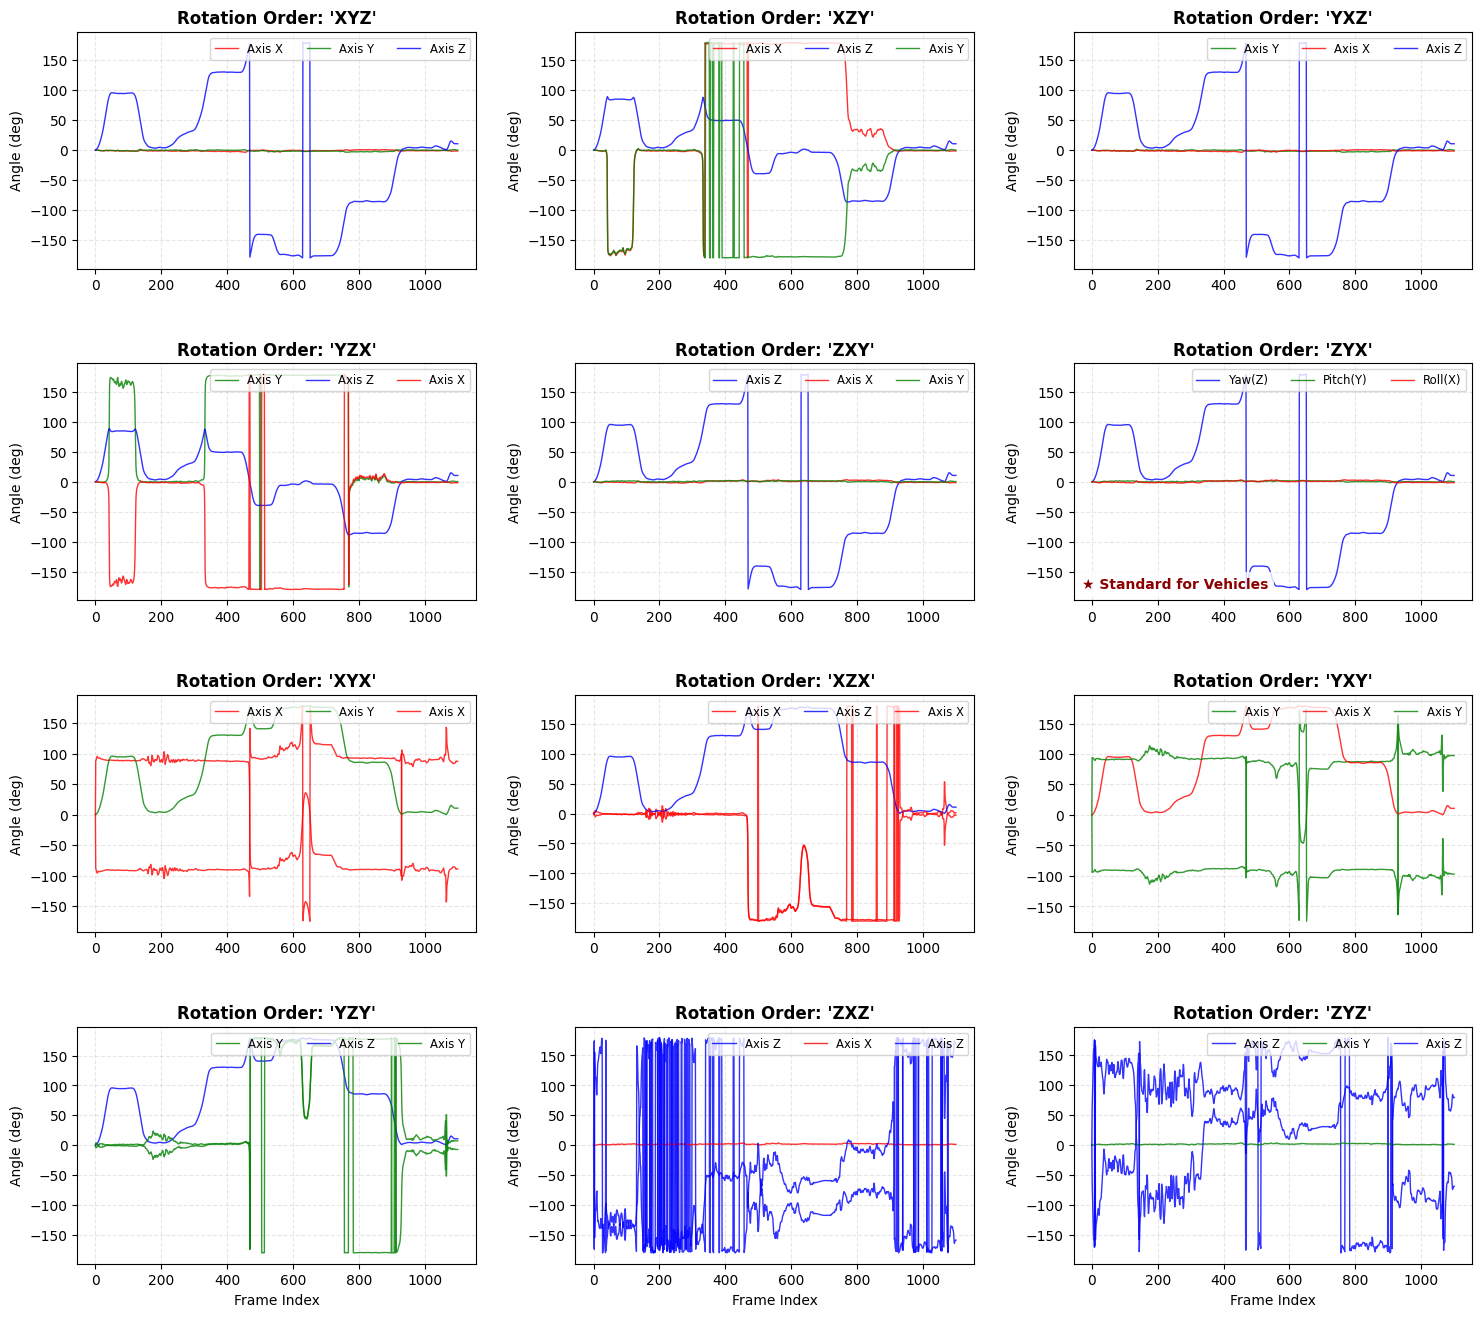

[Gimbal Lock Warning] 以下欧拉角分解顺序在计算过程中检测到万向锁：
  - XYX
  - XZX
  - YXY
  - YZY
  - ZXZ
  - ZYZ


In [3]:
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import numpy as np
import warnings  # 新增：用于捕获万向锁相关的 UserWarning

def visualize_trajectory_and_euler(handler):
    """
    综合可视化：
    1. （预留）可结合 3D 轨迹绘制：在世界坐标系下展示 Camera / 传感器的完整运动轨迹
       （当前函数主体专注于欧拉角对比，如需 3D 轨迹，可在本函数中额外添加对应子图）
    2. 计算并对比「全部常见欧拉角分解顺序」，包含：
       - Tait-Bryan (XYZ 型，不同轴)：XYZ, XZY, YXZ, YZX, ZXY, ZYX
       - Proper Euler (XYX 型，首尾轴相同)：XYX, XZX, YXY, YZY, ZXZ, ZYZ
       所有顺序都参与计算，每个顺序对应一张子图，子图按网格形式排布：
       每行 3 张子图（即一行绘制 3 张），多行自动填充。
    """
    # 1. 准备数据：从 handler 中逐帧提取 LiDAR 在世界坐标系下的位姿
    num_frames = len(handler.raw_camera_poses)

    # 1.1 定义需要对比的“全部常见欧拉角分解顺序”
    #     - 前 6 个为 Tait-Bryan：三个旋转轴均不相同
    #     - 后 6 个为 Proper Euler：首尾轴相同，中间轴不同
    orders = [
        # Tait-Bryan sequences (XYZ 型)
        'XYZ', 'XZY', 'YXZ', 'YZX', 'ZXY', 'ZYX',
        # Proper Euler sequences (XYX 型)
        'XYX', 'XZX', 'YXY', 'YZY', 'ZXZ', 'ZYZ'
    ]
    
    rot_matrices = []   # 存放每一帧的 3x3 旋转矩阵
    translations = []   # 存放每一帧的平移向量 (x, y, z)
    
    for i in range(num_frames):
        # 从 handler 获取第 i 帧 LiDAR 在世界坐标系下的 4x4 齐次变换矩阵
        pose = handler.get_pose_in_world(i, 'lidar')
        rot_matrices.append(pose[:3, :3])   # 旋转部分 R
        translations.append(pose[:3, 3])    # 平移部分 t
        
    translations = np.array(translations)   # (N, 3)，如果后续需要可用于轨迹可视化
    r_all = R.from_matrix(rot_matrices)     # 一次性创建批量 Rotation 对象，加速后续 as_euler 调用
    
    # 2. 设置画布布局（使用 GridSpec）
    #    这里仅用于欧拉角序列对比：
    #    - 每个欧拉角顺序对应一个子图
    #    - 每行固定显示 3 个子图（满足“一行绘制3张”）
    #    - 行数根据欧拉角顺序的数量自动计算
    num_orders = len(orders)
    cols = 3                                        # 每行 3 列子图
    rows = int(np.ceil(num_orders / cols))         # 需要的行数，自动向上取整
    
    # 可以根据行数适当调整画布高度，这里简单设定一个较大的图像尺寸以便阅读
    fig = plt.figure(figsize=(6 * cols, 4 * rows))
    gs = fig.add_gridspec(rows, cols, hspace=0.4, wspace=0.25)
    
    # ==========================================
    # 欧拉角子图：按行 3 张的方式排列所有顺序
    # ==========================================
    # 颜色映射：确保不同顺序下，同一物理轴采用统一颜色
    # 约定: X轴(Roll) = 红, Y轴(Pitch) = 绿, Z轴(Yaw) = 蓝
    axis_colors = {'X': 'r', 'Y': 'g', 'Z': 'b'}

    # 新增：用于记录在哪些欧拉顺序下触发过万向锁
    gimbal_lock_orders = set()
    
    for idx, seq in enumerate(orders):
        # 当前欧拉顺序在网格中的行列索引
        row = idx // cols       # 第几行
        col = idx % cols        # 该行中的第几个
        
        ax = fig.add_subplot(gs[row, col])
        
        # 计算该顺序下的欧拉角序列
        # 使用 warnings.catch_warnings 捕获 as_euler 内部可能产生的
        # “Gimbal lock detected” 的 UserWarning，并记录下来。
        with warnings.catch_warnings(record=True) as w_list:
            warnings.simplefilter("always", UserWarning)
            angles = r_all.as_euler(seq, degrees=True)

            # 检查本次调用是否出现“Gimbal lock detected”类型的警告
            for w in w_list:
                if issubclass(w.category, UserWarning) and \
                   "Gimbal lock detected" in str(w.message):
                    gimbal_lock_orders.add(seq)
                    # 一旦检测到万向锁，当前顺序无需再重复标记，直接 break
                    break
        
        # 绘制该顺序下的 3 条欧拉角曲线
        labels = list(seq)  # 例如 seq='ZYX' -> ['Z','Y','X']
        for i, axis_char in enumerate(labels):
            color = axis_colors.get(axis_char.upper(), 'k')
            
            # 智能图例：如果是 ZYX 顺序，直接标明常用物理含义（车辆常用）
            if seq == 'ZYX':
                phys_name = ['Yaw(Z)', 'Pitch(Y)', 'Roll(X)'][i]
            else:
                # 其他顺序统一采用 “Axis X/Y/Z” 的标注方式
                phys_name = f"Axis {axis_char.upper()}"
                
            ax.plot(
                angles[:, i],
                color=color,
                alpha=0.8,
                linewidth=1,
                label=phys_name
            )
            
        ax.set_title(
            f"Rotation Order: '{seq.upper()}'",
            fontsize=12,
            fontweight='bold'
        )
        ax.set_ylabel("Angle (deg)")
        ax.grid(True, alpha=0.3, linestyle='--')
        ax.legend(loc='upper right', fontsize='small', ncol=3)
        
        # 仅在最后一行的子图上显示横坐标标签，以避免重复
        if row == rows - 1:
            ax.set_xlabel("Frame Index")
            
        # 对 ZYX 顺序做额外标注：这是车辆 / 航空等领域常用的 Yaw-Pitch-Roll 顺序
        if seq == 'ZYX':
            ax.text(
                0.02, 0.05,
                "★ Standard for Vehicles",
                transform=ax.transAxes,
                color='darkred',
                fontweight='bold',
                bbox=dict(facecolor='white', alpha=0.8, edgecolor='none')
            )

    plt.show()

    # ===========================
    # 新增功能：打印万向锁信息
    # ===========================
    if gimbal_lock_orders:
        print("[Gimbal Lock Warning] 以下欧拉角分解顺序在计算过程中检测到万向锁：")
        for seq in sorted(gimbal_lock_orders):
            print(f"  - {seq}")
    else:
        print("[Gimbal Lock] 本次数据中，所有欧拉角分解顺序均未触发万向锁。")


fig2d = plot_trajectory(handler, sensor_type='lidar', dim='2d', arrow_step=150)
visualize_trajectory_and_euler(handler)


#### 稳定且优秀的顺序

使用全部顺序按照内旋规则求解，比较正常的有：XYZ, YXZ, ZXY, ZYX。

它们绕Z轴旋转角度的变化稳定且符合物理直觉，绕X、Y轴旋转的角度则始终平稳接近0，同样符合物理直觉。这四种顺序的可视化结果看起来近乎一致。

看起来近乎一致的原因是X Roll、Y pitch角度都很小，根据小角近似，它们近乎相等。

#### 不稳定的原因分析

注意到这四种顺序排除了XZY、YZX，被排除的两种中间轴都是Z，而Z轴对应角度在运动过程中变化很大。

事实上，Z轴对应角度显然包括90度，期望它出现万向锁警告才对。没出现只能怀疑是采样数据没有精确等于90度的了。

#### XYX型全部不稳定

此外，XYX型的6种内旋求解，都出现了万向锁的问题。

### 以ZYX为基准的误差分析


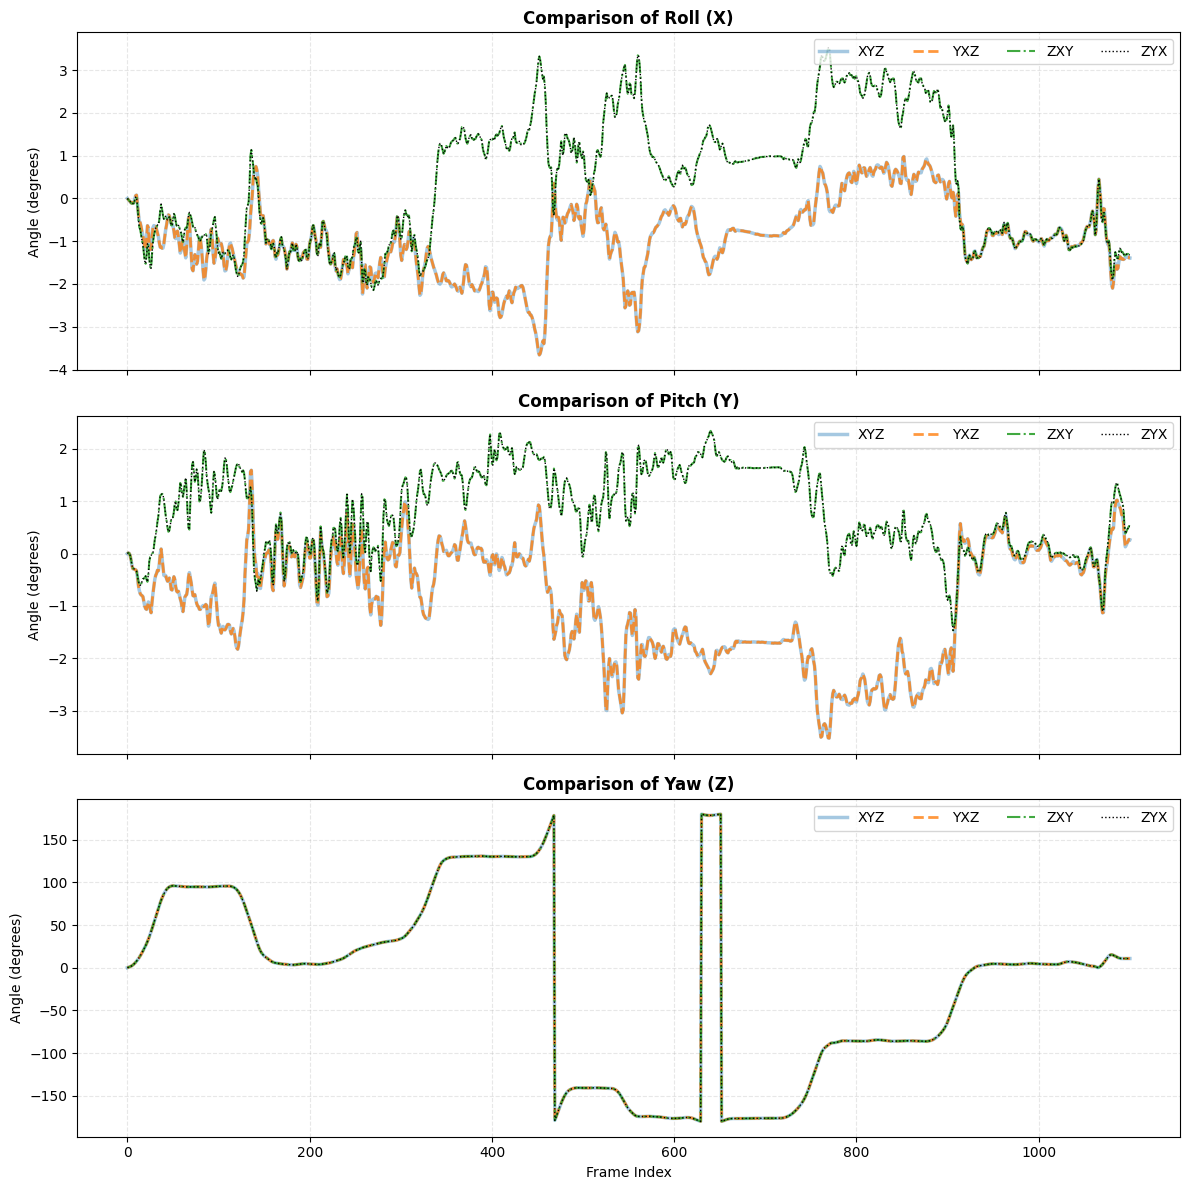

【差异性统计】 (以 ZYX 为基准的最大绝对误差/度)
--------------------------------------------------
Seq    | Max Diff Roll   | Max Diff Pitch  | Max Diff Yaw   
--------------------------------------------------
XYZ    | 6.978175        | 4.981212        | 0.124681       
YXZ    | 6.977719        | 4.982530        | 0.080604       
ZXY    | 0.002169        | 0.003476        | 0.120034       
--------------------------------------------------


In [4]:
import matplotlib.pyplot as plt
from scipy.spatial.transform import Rotation as R
import numpy as np

def compare_euler_orders_raw(handler):
    """
    绘制三张子图，分别对比 'XYZ', 'YXZ', 'ZXY', 'ZYX' 四种顺序在
    Roll (X), Pitch (Y), Yaw (Z) 三个物理轴上的解算数值。
    """
    # 1. 准备数据
    num_frames = len(handler.raw_camera_poses)
    rot_matrices = [handler.get_pose_in_world(i, 'lidar')[:3, :3] for i in range(num_frames)]
    r_all = R.from_matrix(rot_matrices)

    # 2. 定义要对比的四个“好”顺序
    orders = ['XYZ', 'YXZ', 'ZXY', 'ZYX']
    
    # 颜色和线型映射，为了在重合时也能看清
    styles = {
        'XYZ': {'color': 'tab:blue',   'ls': '-',  'lw': 2.5, 'alpha': 0.4},
        'YXZ': {'color': 'tab:orange', 'ls': '--', 'lw': 2.0, 'alpha': 0.8},
        'ZXY': {'color': 'tab:green',  'ls': '-.', 'lw': 1.5, 'alpha': 0.9},
        'ZYX': {'color': 'k',          'ls': ':',  'lw': 1.0, 'alpha': 1.0}  # ZYX 设为黑色虚线，作为基准
    }

    # 3. 创建画布：3行1列，分别对应 Roll, Pitch, Yaw
    fig, axes = plt.subplots(3, 1, figsize=(12, 12), sharex=True)
    
    # 定义物理轴的绘图配置
    # axis_char: 物理轴名称
    # ax_idx: 子图索引
    phys_axes = [
        {'char': 'X', 'name': 'Roll (X)',  'ax_idx': 0},
        {'char': 'Y', 'name': 'Pitch (Y)', 'ax_idx': 1},
        {'char': 'Z', 'name': 'Yaw (Z)',   'ax_idx': 2}
    ]

    # 4. 循环计算并绘图
    # 外层循环：遍历每一种旋转顺序 (XYZ, YXZ...)
    for seq in orders:
        # 计算该顺序下的所有欧拉角 (N, 3)
        # 注意：这里的列顺序对应 seq 字符串的字符顺序
        angles_all = r_all.as_euler(seq, degrees=True)
        
        # 内层循环：遍历三个物理轴 (X, Y, Z)，把数据画到对应的子图上
        for p_ax in phys_axes:
            ax = axes[p_ax['ax_idx']]
            target_char = p_ax['char']
            
            # 核心逻辑：动态寻找物理轴在当前 seq 中的列索引
            # 例如 seq='ZXY', target='X' -> index=1
            col_idx = seq.index(target_char)
            
            # 提取该物理轴的数据
            vals = angles_all[:, col_idx]
            
            # 绘制曲线
            ax.plot(vals, 
                    label=seq, 
                    color=styles[seq]['color'], 
                    linestyle=styles[seq]['ls'],
                    linewidth=styles[seq]['lw'],
                    alpha=styles[seq]['alpha'])

    # 5. 美化图表
    for p_ax in phys_axes:
        ax = axes[p_ax['ax_idx']]
        ax.set_title(f"Comparison of {p_ax['name']}", fontsize=12, fontweight='bold')
        ax.set_ylabel("Angle (degrees)")
        ax.grid(True, linestyle='--', alpha=0.3)
        ax.legend(loc='upper right', ncol=4)
        
        # 针对 Yaw 轴稍微调整一下，因为它可能有跳变，不需要太关注大范围
        if p_ax['char'] == 'Z':
            ax.set_xlabel("Frame Index")

    plt.tight_layout()
    plt.show()

    # 6. (可选) 计算并打印最大差异统计
    # 以 ZYX 为基准，看其他三个顺序与它的最大绝对误差
    print("【差异性统计】 (以 ZYX 为基准的最大绝对误差/度)")
    print("-" * 50)
    print(f"{'Seq':<6} | {'Max Diff Roll':<15} | {'Max Diff Pitch':<15} | {'Max Diff Yaw':<15}")
    print("-" * 50)
    
    base_angles = r_all.as_euler('ZYX', degrees=True)
    base_dict = {'Z': base_angles[:, 0], 'Y': base_angles[:, 1], 'X': base_angles[:, 2]}
    
    for seq in ['XYZ', 'YXZ', 'ZXY']:
        curr_angles = r_all.as_euler(seq, degrees=True)
        diffs = []
        for char in ['X', 'Y', 'Z']:
            col = seq.index(char)
            # 处理 Yaw 的 360 度周期性问题，取最小相位差
            d = curr_angles[:, col] - base_dict[char]
            if char == 'Z':
                d = (d + 180) % 360 - 180
            diffs.append(np.max(np.abs(d)))
            
        print(f"{seq:<6} | {diffs[0]:<15.6f} | {diffs[1]:<15.6f} | {diffs[2]:<15.6f}")
    print("-" * 50)

compare_euler_orders_raw(handler)

### question 1 欧拉角计算与分析
- 从数据库中提供的 Tr 矩阵中计算出俯仰、滚动、偏航等三个欧拉角。
- （KITTI 数据库并未指定欧拉角的旋转顺序，你可以尝试采用不同的旋转次序，比较不同次序恢复出的角度是否一致？哪一个次序更为合理？）

### answer 1 
不一致。XYZ，YXZ，ZXY，ZYX都比较合理。

## Q2

In [5]:
import numpy as np
from scipy.spatial.transform import Rotation as R

def analyze_rotation_representations(handler):
    """
    计算并对比：旋转矩阵 vs 欧拉角 (ZYX) vs 四元数
    针对对象：
    1. 静态标定矩阵 Tr (LiDAR -> Camera)
    2. 动态位姿 Frame 0 和 Frame 1 (LiDAR in World)
    """
    
    # 辅助函数：打印单一矩阵的详细信息
    def print_rotation_info(name, matrix_4x4):
        print(f"[{name}] Analysis:")
        print("-" * 50)
        
        # 1. 提取旋转矩阵 (3x3)
        rot_mat = matrix_4x4[:3, :3]
        print(f"1. Rotation Matrix (3x3):\n{rot_mat}")
        
        # 创建 Scipy Rotation 对象
        r = R.from_matrix(rot_mat)
        
        # 2. 计算欧拉角 (ZYX顺序：Yaw-Pitch-Roll)
        # 这是车辆和航空中最常用的顺序
        euler = r.as_euler('ZYX', degrees=True)
        print(f"\n2. Euler Angles (ZYX order, degrees):")
        print(f"   Yaw   (Z): {euler[0]:>10.4f} deg  (航向)")
        print(f"   Pitch (Y): {euler[1]:>10.4f} deg  (俯仰)")
        print(f"   Roll  (X): {euler[2]:>10.4f} deg  (横滚)")
        
        # 3. 计算四元数 (x, y, z, w)
        quat = r.as_quat()
        print(f"\n3. Quaternion (x, y, z, w):")
        print(f"   vec: [{quat[0]:.4f}, {quat[1]:.4f}, {quat[2]:.4f}, {quat[3]:.4f}]")
        
        # 验证单位四元数性质
        norm = np.linalg.norm(quat)
        print(f"   Norm: {norm:.6f} (Check: Should be close to 1.0)")
        print("=" * 60 + "\n")

    print("\n========== 任务 6：旋转矩阵 -> 欧拉角 vs 四元数 ==========\n")

    # --- Part A: 静态标定矩阵 Tr (LiDAR 到 Camera 的安装误差) ---
    # 这对应作业中提到的 "从数据库提供的 Tr 矩阵中计算..."
    print_rotation_info("Static Calibration Tr (LiDAR -> Camera)", handler.Tr)

    # --- Part B: 动态轨迹第 0 帧 (车辆起始位姿) ---
    pose_0 = handler.get_pose_in_world(0, 'lidar')
    print_rotation_info("Frame 0 Pose (LiDAR World)", pose_0)

    # --- Part C: 动态轨迹第 1 帧 (车辆刚动了一点点) ---
    pose_1 = handler.get_pose_in_world(1, 'lidar')
    print_rotation_info("Frame 1 Pose (LiDAR World)", pose_1)

    # --- Part D: 简单的数值对比分析 ---
    print(">>> 简要对比总结 (Summary):")
    
    # 计算 Frame 0 到 Frame 1 的旋转变化
    r0 = R.from_matrix(pose_0[:3, :3])
    r1 = R.from_matrix(pose_1[:3, :3])
    # 相对旋转: R_rel = R1 * inv(R0)
    r_rel = r1 * r0.inv()
    
    euler_diff = r_rel.as_euler('ZYX', degrees=True)
    quat_diff = r_rel.as_quat()
    
    print(f"Frame 0 -> Frame 1 变化量:")
    print(f"欧拉角变化 (ZYX): Yaw={euler_diff[0]:.4f}, Pitch={euler_diff[1]:.4f}, Roll={euler_diff[2]:.4f}")
    print(f"四元数直接数值差异不直观，体现了其'黑盒'特性。")


# 运行分析函数
analyze_rotation_representations(handler)


========== 任务 6：旋转矩阵 -> 欧拉角 vs 四元数 ==========

[Static Calibration Tr (LiDAR -> Camera)] Analysis:
--------------------------------------------------
1. Rotation Matrix (3x3):
[[-0.00185774 -0.99996595 -0.00803998]
 [-0.00648147  0.00805186 -0.99994661]
 [ 0.99997731 -0.00180553 -0.0064962 ]]

2. Euler Angles (ZYX order, degrees):
   Yaw   (Z):  -105.9936 deg  (航向)
   Pitch (Y):   -89.6137 deg  (俯仰)
   Roll  (X):  -164.4674 deg  (横滚)

3. Quaternion (x, y, z, w):
   vec: [-0.4991, 0.5041, -0.4968, -0.4999]
   Norm: 1.000000 (Check: Should be close to 1.0)

[Frame 0 Pose (LiDAR World)] Analysis:
--------------------------------------------------
1. Rotation Matrix (3x3):
[[ 1.00000000e+00 -1.67503520e-10 -3.57553732e-10]
 [-1.67503534e-10  1.00000000e+00  1.37087831e-11]
 [-3.57553740e-10  1.37087837e-11  1.00000000e+00]]

2. Euler Angles (ZYX order, degrees):
   Yaw   (Z):    -0.0000 deg  (航向)
   Pitch (Y):     0.0000 deg  (俯仰)
   Roll  (X):     0.0000 deg  (横滚)

3. Quaternion (x, y, z

In [6]:
import numpy as np
from scipy.spatial.transform import Rotation as R

# ==========================================
# 0. 基础工具函数 (你提供的)
# ==========================================
def get_rotation_matrix(axis, degrees):
    """ 生成基础旋转矩阵 """
    rad = np.radians(degrees)
    c, s = np.cos(rad), np.sin(rad)
    if axis == 'x':
        return np.array([[1, 0, 0], [0, c, -s], [0, s, c]])
    elif axis == 'y':
        return np.array([[c, 0, s], [0, 1, 0], [-s, 0, c]])
    elif axis == 'z':
        return np.array([[c, -s, 0], [s, c, 0], [0, 0, 1]])

def is_same_matrix(m1, m2):
    """ 判断两个矩阵是否（几乎）相等 """
    return np.allclose(m1, m2, atol=1e-6)

# ==========================================
# 1. 制造万向锁 (Gimbal Lock)
# ==========================================
print("【步骤 1】制造万向锁场景")

# 设定 ZYX 顺序的角度：
# 关键点：Pitch (Y轴) 设为 90度 -> 触发万向锁
# 我们随意设定的“真值”：Yaw=30, Pitch=90, Roll=0
yaw_true   = 30
pitch_lock = 90
roll_true  = 0

# 生成对应的旋转矩阵 R_target
# ZYX顺序矩阵乘法: R = Rz * Ry * Rx
R_z = get_rotation_matrix('z', yaw_true)
R_y = get_rotation_matrix('y', pitch_lock)
R_x = get_rotation_matrix('x', roll_true)

target_matrix = R_z @ R_y @ R_x

print(f"设定目标姿态: Yaw={yaw_true}, Pitch={pitch_lock}, Roll={roll_true}")
print("生成的旋转矩阵 (Target Matrix):\n", np.round(target_matrix, 4))
print("-" * 50)


# ==========================================
# 2. 欧拉角的非唯一性 (Non-Uniqueness)
# ==========================================
print("\n【步骤 2】欧拉角解的不唯一性验证")

# --- 解法 A：使用 Scipy 求解 (代表通用算法) ---
# Scipy 在遇到万向锁时，通常会强制令 Roll=0 (或 Yaw=0) 来求得一个特解
r_obj = R.from_matrix(target_matrix)
sol_A = r_obj.as_euler('ZYX', degrees=True)
print(f"解 A (Scipy 算法求解):  Yaw={sol_A[0]:.2f}, Pitch={sol_A[1]:.2f}, Roll={sol_A[2]:.2f}")

# --- 解法 B：手动构造另一个“看起来完全不同”的解 ---
# 原理：在 ZYX 且 Pitch=90 时，Yaw 和 Roll 是耦合的。
# 对于 ZYX 内旋，Yaw - Roll = Constant (或者 Yaw + Roll，取决于轴向定义)
# 只要保持 (Yaw - Roll) 的差值不变，旋转矩阵就不变。

# 让我们构造一个完全不同的 Yaw 和 Roll
# 真值是 Yaw=30, Roll=0 -> 差值 30
# 我们构造: Yaw=50, Roll=20 -> 差值 30
yaw_B  = 50
roll_B = 20

print(f"解 B (手动构造伪解):    Yaw={yaw_B:.2f}, Pitch={pitch_lock:.2f}, Roll={roll_B:.2f}")

# --- 验证：两个不同的解，是否生成了同一个矩阵？ ---
R_z_B = get_rotation_matrix('z', yaw_B)
R_y_B = get_rotation_matrix('y', pitch_lock)
R_x_B = get_rotation_matrix('x', roll_B)
matrix_B = R_z_B @ R_y_B @ R_x_B

print("\n验证矩阵一致性:")
if is_same_matrix(target_matrix, matrix_B):
    print(">>> 成功复现万向锁现象！")
    print(f"虽然欧拉角截然不同:\n A: {sol_A}\n B: [{yaw_B}, {pitch_lock}, {roll_B}]")
    print("但它们对应的旋转矩阵 完全相同。")
else:
    print(">>> 验证失败，构造逻辑有误。")
print("-" * 50)


# ==========================================
# 3. 四元数的唯一性 (Uniqueness)
# ==========================================
print("\n【步骤 3】四元数的唯一性验证")

# 将 解A (Scipy解) 转为四元数
quat_A = R.from_euler('ZYX', sol_A, degrees=True).as_quat()

# 将 解B (手动构造解) 转为四元数
quat_B = R.from_euler('ZYX', [yaw_B, pitch_lock, roll_B], degrees=True).as_quat()

print(f"解 A 对应的四元数: {np.round(quat_A, 4)}")
print(f"解 B 对应的四元数: {np.round(quat_B, 4)}")

# 比较两个四元数
# 注意：四元数 q 和 -q 代表相同的旋转 (双倍覆盖)，通常比较绝对值或点积
if np.allclose(quat_A, quat_B, atol=1e-6) or np.allclose(quat_A, -quat_B, atol=1e-6):
    print("\n>>> 结论验证成功：")
    print("尽管输入的欧拉角不同，但输出的四元数是 唯一且稳定 的。")
    print("四元数准确描述了刚体在空间的实际姿态，没有被分解方式的奇异性干扰。")
else:
    print(">>> 验证失败。")

【步骤 1】制造万向锁场景
设定目标姿态: Yaw=30, Pitch=90, Roll=0
生成的旋转矩阵 (Target Matrix):
 [[ 0.    -0.5    0.866]
 [ 0.     0.866  0.5  ]
 [-1.     0.     0.   ]]
--------------------------------------------------

【步骤 2】欧拉角解的不唯一性验证
解 A (Scipy 算法求解):  Yaw=30.00, Pitch=90.00, Roll=0.00
解 B (手动构造伪解):    Yaw=50.00, Pitch=90.00, Roll=20.00

验证矩阵一致性:
>>> 成功复现万向锁现象！
虽然欧拉角截然不同:
 A: [30. 90.  0.]
 B: [50, 90, 20]
但它们对应的旋转矩阵 完全相同。
--------------------------------------------------

【步骤 3】四元数的唯一性验证
解 A 对应的四元数: [-0.183  0.683  0.183  0.683]
解 B 对应的四元数: [-0.183  0.683  0.183  0.683]

>>> 结论验证成功：
尽管输入的欧拉角不同，但输出的四元数是 唯一且稳定 的。
四元数准确描述了刚体在空间的实际姿态，没有被分解方式的奇异性干扰。


/tmp/ipykernel_59824/1668738765.py:55: UserWarning: Gimbal lock detected. Setting third angle to zero since it is not possible to uniquely determine all angles.
  sol_A = r_obj.as_euler('ZYX', degrees=True)


### question 姿态表示方法比较
- 从 Tr 矩阵中计算出单位四元数，比较四元数和欧拉角表示方法。
- 欧拉角中著名的 Gimbal Lock 问题在该组数据中或是在一般的地面无人平台数据中是否会出现？
- 欧拉角表示方法对于地面无人平台来说是否就足够用？
- 四元数的优点究竟体现在哪些方面？

### answer
- 选取合适的求解顺序，如ZYX，则在地面无人平台中不会出现万向锁，因为俯仰角不可能等于90°。
- 似乎欧拉角的表示是够用的。
- 对于无人车，我只能想到四元数的优点是无需指定轴的顺序、没有歧义。AI认为四元数的表示方法在对位姿进行其他算法的优化处理时会更稳定，但是还无法验证。

## Q3

### question 点云地图构建

In [7]:
import os

class LiDARLoader:
    """
    封装的雷达数据加载器，支持多种采样模式
    """
    def __init__(self, base_dir):
        self.velo_dir = os.path.join(base_dir, 'velodyne')
        
    def _detect_ring_boundaries(self, points):
        """
        [私有方法] 基于方位角突变检测线束边界
        """
        x = points[:, 0]
        y = points[:, 1]
        azimuth = np.arctan2(y, x)
        diffs = np.diff(azimuth)
        # 寻找突变点 (Wrap-around indices)
        split_indices = np.where(np.abs(diffs) > 5.0)[0] + 1
        return np.concatenate(([0], split_indices, [len(points)]))

    def read_frame(self, frame_id, 
                   sampling_method='structured', # 'uniform' 或 'structured'
                   uniform_step=1,            # 均匀采样参数
                   struct_vert_step=1,        # 结构化-垂直参数
                   struct_horiz_step=1,       # 结构化-水平参数
                   enable_distance_filter=True,
                   min_dist=3.0, max_dist=50.0):
        """
        读取指定帧的点云，支持灵活的过滤和采样
        """
        # 1. 构造文件路径
        file_name = f"{frame_id:06d}.bin"
        file_path = os.path.join(self.velo_dir, file_name)
        
        if not os.path.exists(file_path):
            raise FileNotFoundError(f"File not found: {file_path}")
            
        # 2. 读取点云 (N × 4)
        points = np.fromfile(file_path, dtype=np.float32).reshape((-1, 4))
        
        # 3. 距离过滤 (建议在结构化采样前做，或者采样后做均可，这里选择先过滤减小计算量)
        # 注意：只要不破坏角度的单调性，距离过滤不会影响后续的Ring检测
        if enable_distance_filter:
            dist_sq = points[:, 0]**2 + points[:, 1]**2
            mask = (dist_sq > min_dist**2) & (dist_sq < max_dist**2)
            points = points[mask]
            
        # 4. 执行降采样
        if sampling_method == 'uniform':
            if uniform_step > 1:
                points = points[::uniform_step]
                
        elif sampling_method == 'structured':
            # 仅当需要降采样时才计算
            if struct_vert_step > 1 or struct_horiz_step > 1:
                boundaries = self._detect_ring_boundaries(points)
                sampled_chunks = []
                
                # 遍历每一圈 (Ring)
                # vertical_step 控制跳过多少圈
                for i in range(0, len(boundaries) - 1, struct_vert_step):
                    start = boundaries[i]
                    end = boundaries[i+1]
                    # horizontal_step 控制圈内稀疏度
                    chunk = points[start:end:struct_horiz_step]
                    sampled_chunks.append(chunk)
                
                if len(sampled_chunks) > 0:
                    points = np.concatenate(sampled_chunks, axis=0)
                else:
                    points = np.zeros((0, 4), dtype=np.float32)
        else:
            raise ValueError(f"Unknown sampling method: {sampling_method}")
            
        return points

# 根据你提供的目录结构 
DATA_PATH = '../data/07/' 
VELODYNE_PATH = os.path.join(DATA_PATH, 'velodyne')



初始化完成:
- 标定矩阵 Tr shape: (4, 4)
- 位姿总帧数: 1101
开始拼接: Frame 0 -> 5 (Step: 1)
Loader 配置: 默认 (Default)
  Frame 0: 121881 points added.
拼接完成! 总点数: 609220
可视化采样点数: 12185 (原始 1/50)


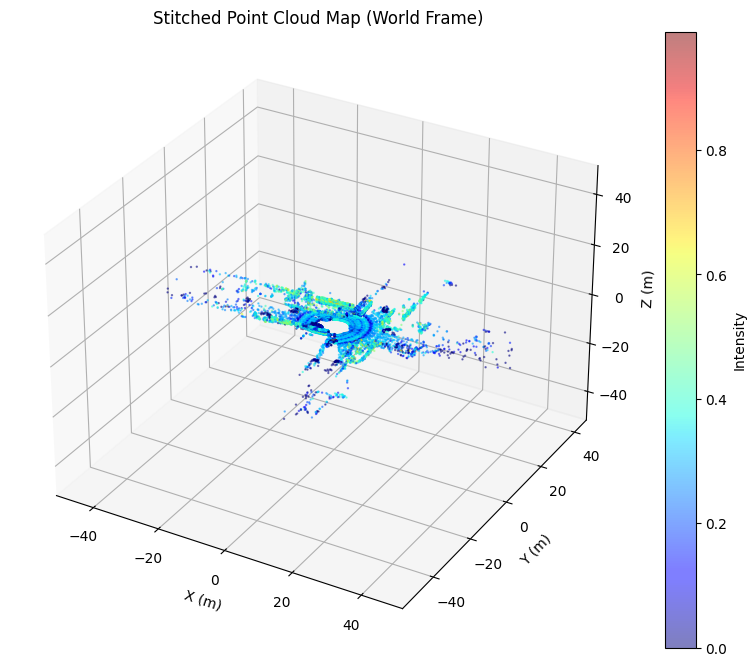

In [8]:
import numpy as np
import matplotlib.pyplot as plt

import numpy as np
import matplotlib.pyplot as plt
# 引入 os 模块，以防万一
import os 

class PointCloudMapper:
    def __init__(self, lidar_loader, pose_handler):
        """
        :param lidar_loader: LiDARLoader 实例
        :param pose_handler: KittiPoseHandler 实例
        """
        self.loader = lidar_loader
        self.pose_handler = pose_handler
        self.map_points = None
        
    def _transform_batch(self, points, pose):
        """内部函数：坐标变换 (保持不变)"""
        if len(points) == 0:
            return points
            
        xyz = points[:, :3]
        intensity = points[:, 3:4]
        
        # 齐次变换
        ones = np.ones((xyz.shape[0], 1))
        xyz_hom = np.hstack((xyz, ones))
        xyz_world_hom = (pose @ xyz_hom.T).T
        
        return np.hstack((xyz_world_hom[:, :3], intensity))

    def build_map(self, start_frame, end_frame, step=1, **loader_args):
        """
        构建局部地图 (支持透传参数给 LiDARLoader)
        
        :param start_frame: 起始帧
        :param end_frame: 结束帧
        :param step: 帧步长 (处理进度上的步长)
        :param loader_args: 直接传递给 loader.read_frame 的参数
                            例如: max_dist=100.0, sampling_method='structured'
        """
        # 打印当前的配置，方便调试
        print(f"开始拼接: Frame {start_frame} -> {end_frame} (Step: {step})")
        print(f"Loader 配置: {loader_args if loader_args else '默认 (Default)'}")
        
        all_points_list = []
        
        for frame_id in range(start_frame, end_frame, step):
            try:
                # =========================================
                # 核心修改：直接将 **loader_args 传给 read_frame
                # =========================================
                local_points = self.loader.read_frame(frame_id, **loader_args)
                
                # 如果过滤得只剩下0个点，跳过计算
                if len(local_points) == 0:
                    continue

                # 获取位姿并变换
                pose = self.pose_handler.get_pose_in_world(frame_id, sensor_type='lidar')
                world_points = self._transform_batch(local_points, pose)
                
                all_points_list.append(world_points)
                
                if frame_id % 10 == 0:
                    print(f"  Frame {frame_id}: {len(local_points)} points added.")
                    
            except FileNotFoundError:
                print(f"  [Warn] Frame {frame_id} file not found.")
            except Exception as e:
                print(f"  [Error] Frame {frame_id}: {e}")
                # 遇到严重错误是否break取决于你的需求，通常continue比较稳妥
                continue
                
        # 合并
        if all_points_list:
            self.map_points = np.concatenate(all_points_list, axis=0)
            print(f"拼接完成! 总点数: {self.map_points.shape[0]}")
        else:
            print("警告: 地图为空 (可能参数过滤太严格或未找到文件)")
            self.map_points = None

    def save_pcd(self, filename):
        """保存 PCD (保持不变)"""
        if self.map_points is None:
            print("Map is empty.")
            return
        
        print(f"Saving to {filename} ...")
        num_points = self.map_points.shape[0]
        with open(filename, 'w') as f:
            headers = [
                '# .PCD v0.7 - Point Cloud Data file format',
                'VERSION 0.7',
                'FIELDS x y z intensity',
                'SIZE 4 4 4 4',
                'TYPE F F F F',
                'COUNT 1 1 1 1',
                f'WIDTH {num_points}',
                'HEIGHT 1',
                'VIEWPOINT 0 0 0 1 0 0 0',
                f'POINTS {num_points}',
                'DATA ascii'
            ]
            f.write('\n'.join(headers) + '\n')
            np.savetxt(f, self.map_points, fmt='%.4f %.4f %.4f %.4f')
        print("Done.")

    def visualize_in_notebook(self, downsample_factor=100):

        """
        在 Notebook 中直接进行简易 3D 可视化
        :param downsample_factor: 降采样因子，仅用于显示，防止浏览器卡死
        """

        if self.map_points is None:
            print("地图为空。")
            return

        # 降采样用于绘图
        display_points = self.map_points[::downsample_factor]
        print(f"可视化采样点数: {len(display_points)} (原始 1/{downsample_factor})")

        fig = plt.figure(figsize=(10, 8))
        ax = fig.add_subplot(111, projection='3d')

        # 提取坐标
        x = display_points[:, 0]
        y = display_points[:, 1]
        z = display_points[:, 2]
        intensity = display_points[:, 3]

        # 绘图 (使用强度作为颜色)
        # s=1 表示点的大小，cmap='gray' 或 'jet' 表示强度颜色映射
        scatter = ax.scatter(x, y, z, c=intensity, cmap='jet', s=0.5, alpha=0.5)

        ax.set_title("Stitched Point Cloud Map (World Frame)")
        ax.set_xlabel("X (m)")
        ax.set_ylabel("Y (m)")
        ax.set_zlabel("Z (m)")

        # 设置等比例轴 (简单的 trick)
        max_range = np.array([x.max()-x.min(), y.max()-y.min(), z.max()-z.min()]).max() / 2.0
        mid_x = (x.max()+x.min()) * 0.5
        mid_y = (y.max()+y.min()) * 0.5
        mid_z = (z.max()+z.min()) * 0.5
        ax.set_xlim(mid_x - max_range, mid_x + max_range)
        ax.set_ylim(mid_y - max_range, mid_y + max_range)
        ax.set_zlim(mid_z - max_range, mid_z + max_range)

        plt.colorbar(scatter, label='Intensity')
        plt.show()

# ==========================================
# 使用示例
# ==========================================
# 假设 pose_handler 和 lidar_loader 已经在前面的代码中实例化了

pose_handler = KittiPoseHandler(base_dir)
lidar_loader = LiDARLoader(base_dir)

mapper = PointCloudMapper(lidar_loader, pose_handler)

# 1. 拼接第 0 到 50 帧，每隔 5 帧取一帧 (快速测试)
mapper.build_map(start_frame=0, end_frame=5)

# 2. 直接在 Notebook 中预览 (降采样显示)
mapper.visualize_in_notebook(downsample_factor=50)

# 3. 保存为 PCD 文件 (以便在 CloudCompare 中查看完整细节)
# mapper.save_pcd("../output/kitti_map_0_50.pcd")

对于前50帧数据，分别使用不采样、均匀采样(1/10)、结构化采样(2*5)

In [9]:
# 确保你已经运行了上面定义 PointCloudMapper (带 **loader_args 版本) 的代码块

# 1. 初始化
base_dir = '../data/07/'  # 请确认你的路径
pose_handler = KittiPoseHandler(base_dir)
lidar_loader = LiDARLoader(base_dir)
mapper = PointCloudMapper(lidar_loader, pose_handler)

output_dir = '../output/' # 假设你有一个输出目录
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# ==================================================
# 任务 1: 不采样 (保留所有点, 0-50帧)
# ==================================================
print("\n>>> 正在生成: map_50_no_sampling.pcd ...")
mapper.build_map(
    start_frame=0, end_frame=50, step=1,
    # Loader 参数:
    sampling_method='uniform',
    uniform_step=1,          # 1/1 = 100% 数据
    enable_distance_filter=True, # 显式开启
    min_dist=3.0, 
    max_dist=50.0            # 默认 50m
)
mapper.save_pcd(os.path.join(output_dir, "map_01_no_sampling.pcd"))


# ==================================================
# 任务 2: Uniform 采样 (1/10 数据量)
# ==================================================
print("\n>>> 正在生成: map_50_uniform_sample.pcd ...")
mapper.build_map(
    start_frame=0, end_frame=50, step=1,
    # Loader 参数:
    sampling_method='uniform',
    uniform_step=10,         # 每10个点取1个
    enable_distance_filter=True,
    min_dist=3.0, 
    max_dist=50.0
)
mapper.save_pcd(os.path.join(output_dir, "map_02_uniform_sample.pcd"))


# ==================================================
# 任务 3: Structured 采样 (1/10 数据量)
# ==================================================
print("\n>>> 正在生成: map_50_structured_sample.pcd ...")
# 策略: 保持垂直线束完整(vert=1)，但在水平旋转方向稀疏化(horiz=10)
# 这样能保留类似"扫描线"的结构，但点数变为 1/10
mapper.build_map(
    start_frame=0, end_frame=50, step=1,
    # Loader 参数:
    sampling_method='structured',
    struct_vert_step=2,      # 不跳过线束 (保留64线)
    struct_horiz_step=5,    # 线束内每10个点取1个
    enable_distance_filter=True,
    min_dist=3.0, 
    max_dist=50.0
)
mapper.save_pcd(os.path.join(output_dir, "map_03_structured_sample.pcd"))

print("\n全部任务完成！请使用 pcl 对比查看这三个文件。")

初始化完成:
- 标定矩阵 Tr shape: (4, 4)
- 位姿总帧数: 1101

>>> 正在生成: map_50_no_sampling.pcd ...
开始拼接: Frame 0 -> 50 (Step: 1)
Loader 配置: {'sampling_method': 'uniform', 'uniform_step': 1, 'enable_distance_filter': True, 'min_dist': 3.0, 'max_dist': 50.0}
  Frame 0: 121881 points added.
  Frame 10: 121728 points added.
  Frame 20: 122049 points added.
  Frame 30: 121122 points added.
  Frame 40: 115639 points added.
拼接完成! 总点数: 5826434
Saving to ../output/map_01_no_sampling.pcd ...
Done.

>>> 正在生成: map_50_uniform_sample.pcd ...
开始拼接: Frame 0 -> 50 (Step: 1)
Loader 配置: {'sampling_method': 'uniform', 'uniform_step': 10, 'enable_distance_filter': True, 'min_dist': 3.0, 'max_dist': 50.0}
  Frame 0: 12189 points added.
  Frame 10: 12173 points added.
  Frame 20: 12205 points added.
  Frame 30: 12113 points added.
  Frame 40: 11564 points added.
拼接完成! 总点数: 582666
Saving to ../output/map_02_uniform_sample.pcd ...
Done.

>>> 正在生成: map_50_structured_sample.pcd ...
开始拼接: Frame 0 -> 50 (Step: 1)
Loader 配置: {'sam

In [10]:
# !pcl_viewer ../output/map_01_no_sampling.pcd

不降采样的前50帧见图。图二可以看到条纹很明显


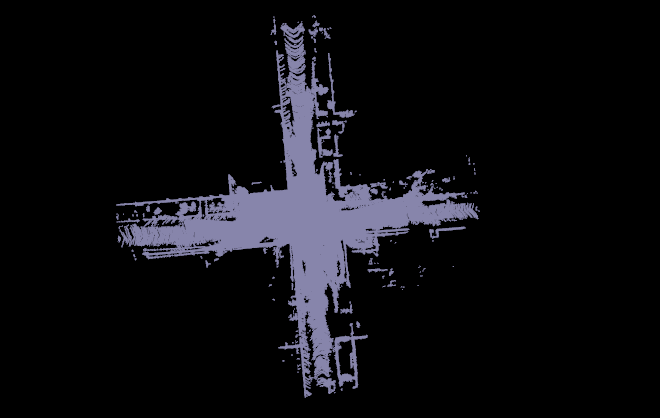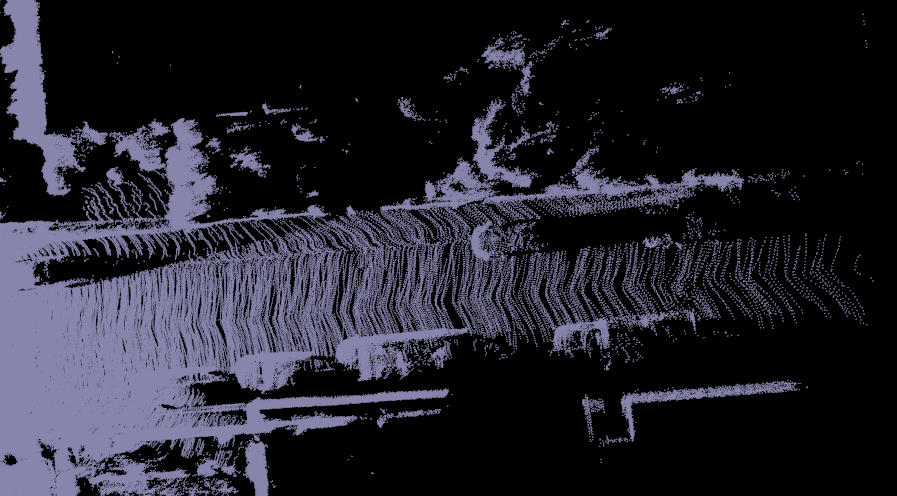

In [11]:
# !pcl_viewer ../output/map_02_uniform_sample.pcd

均匀采样的前50帧见图，图二的条纹完全丧失

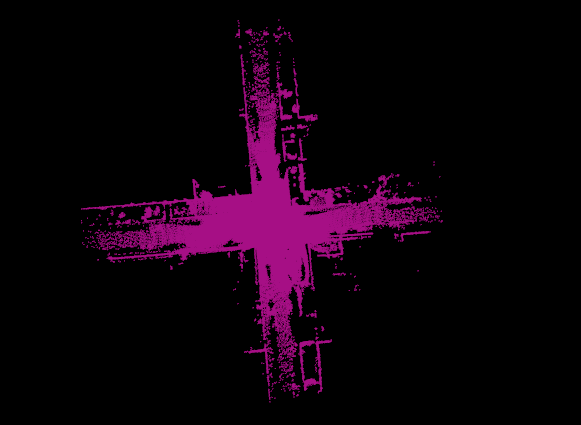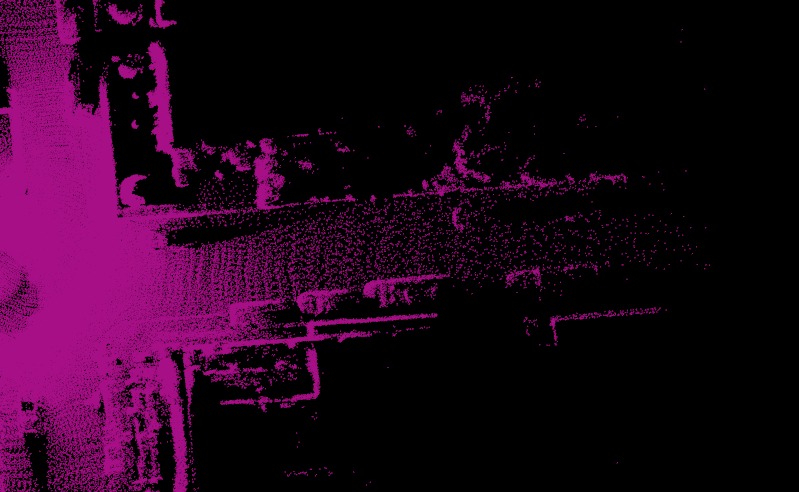

In [12]:
# !pcl_viewer ../output/map_03_structured_sample.pcd

结构化采样的前50帧见图，图二条纹有一点点

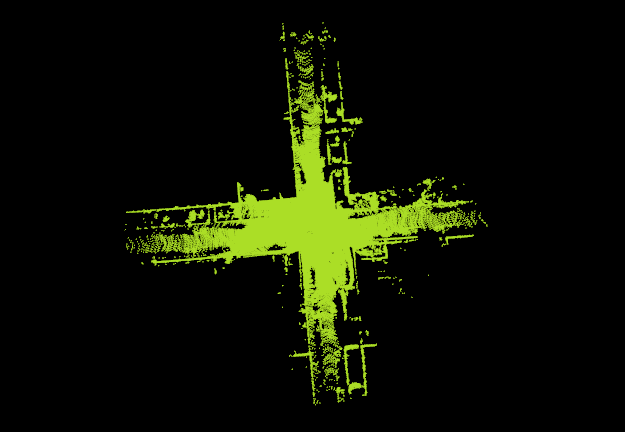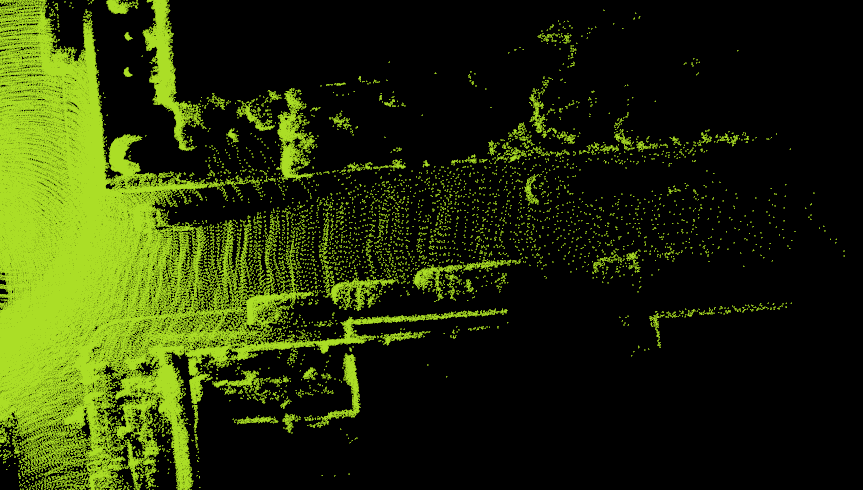

In [13]:
mapper.build_map(
    start_frame=0, end_frame=1000, step=1,
    # Loader 参数:
    sampling_method='structured',
    struct_vert_step=2,      # 不跳过线束 (保留64线)
    struct_horiz_step=5,    # 线束内每10个点取1个
    enable_distance_filter=True,
    min_dist=3.0, 
    max_dist=50.0
)
mapper.save_pcd(os.path.join(output_dir, "map_1000_frames_10_structed_sample.pcd"))

开始拼接: Frame 0 -> 1000 (Step: 1)
Loader 配置: {'sampling_method': 'structured', 'struct_vert_step': 2, 'struct_horiz_step': 5, 'enable_distance_filter': True, 'min_dist': 3.0, 'max_dist': 50.0}
  Frame 0: 12222 points added.
  Frame 10: 12194 points added.
  Frame 20: 12238 points added.
  Frame 30: 12162 points added.
  Frame 40: 11598 points added.
  Frame 50: 7671 points added.
  Frame 60: 11044 points added.
  Frame 70: 11178 points added.
  Frame 80: 11394 points added.
  Frame 90: 11873 points added.
  Frame 100: 12329 points added.
  Frame 110: 8375 points added.
  Frame 120: 10628 points added.
  Frame 130: 11584 points added.
  Frame 140: 12244 points added.
  Frame 150: 11660 points added.
  Frame 160: 11774 points added.
  Frame 170: 12016 points added.
  Frame 180: 11670 points added.
  Frame 190: 8723 points added.
  Frame 200: 11971 points added.
  Frame 210: 10216 points added.
  Frame 220: 11099 points added.
  Frame 230: 9572 points added.
  Frame 240: 10723 points added.

In [14]:
# !pcl_viewer ../output/map_1000_frames_10_structed_sample.pcd

结构化降采样后到1/10后，1000帧全部数据的见图

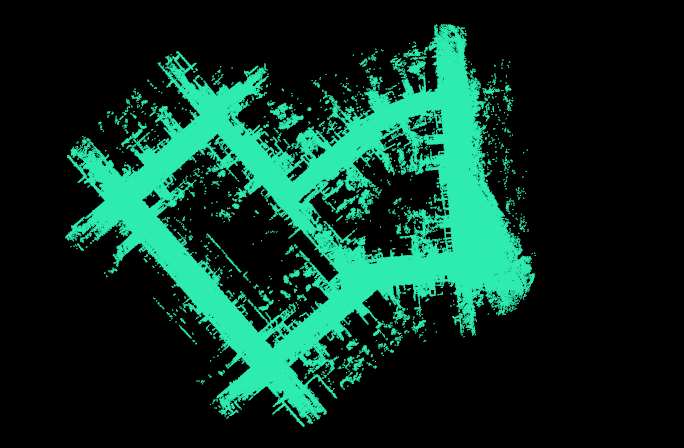